# Time Domain Reflectometry (TDR)

This notebook outlines time domain reflectometry (TDR), a method used to detect faults in electric cables. TDR involves sending a pulse down a cable and analysing the reflected signal. Using time delay between incident and reflected signals (time of propagation of the signal) and the velocity factor (vf) of the cable, we can compute the distance of occurrence of the fault from the input port. In this notebook, we will use data collected from an experiment carried out at the Dedan Kimathi University of Technology (DeKUT) Conservancy. A section of the Conservancy's fence, approximately $107\ m $ long, was used to carry out the experiment. Two topmost cables of the fence were used for this experiment.

<p align="center" width="100%">
    <img width="32%" src="images/tdr-system-connected-to-fence.jpg"> 
    <img width="32%" src="images/tdr-system-closeup.jpg"> 
</p>

Using a TDR system developed at the [Centre for Data Science and Artificial Intelligence (DSAIL)](https://dekut-dsail.github.io/), we simulated open circuit and short circuit faults along the fence, introduced a signal to the fence and sampled it at the input port. The sampled signals were saved for analysis. Using these data, we will develop a TDR algorithm for faults detection in electric fences.

In [1]:
import numpy as np
import configparser
import pandas as pd
import tdr_utils as ut

In [2]:
# Get parameters from configuration file
config = configparser.ConfigParser()
config.read('tdr-parameters.ini')

c = float(config['signal']['c']) #speed of light
vf = float(config['signal']['vf']) #velocity factor
threshold = int(config['signal']['threshold'])
frequency = float(config['signal']['frequency'])
duty_cycle = float(config['signal']['duty_cycle'])
num_samples = int(config['signal']['num_samples'])
sampling_rate = float(config['signal']['sampling_rate'])

num_edges = int(config['search']['num_edges']) #number of rising and falling, each, edges to search for
overlap_offset = int(config['search']['overlap_offset']) #number of samples to offset overlap threshold with

win_size = int(config['win_interest']['win_size']) 
prior_samples = int(config['win_interest']['prior_samples']) # samples to consider before rising/falling edge index

_num_edges = 1
overlap_threshold = duty_cycle * (sampling_rate / frequency) - overlap_offset
t = np.linspace(0, num_samples / sampling_rate, num=num_samples) * 1000 #time in milliseconds

## Pulses applied to open circuited fence

Pulses generated by a pulse generator on the TDR system were applied to the section of the fence at the conservancy. The entire section was used for open circuit simulation. In the following sections we will extract the time of propagation of the signal and use it to compute the velocity factor of the cable and the point of occurrence of the open circuit fault (length of the cable).

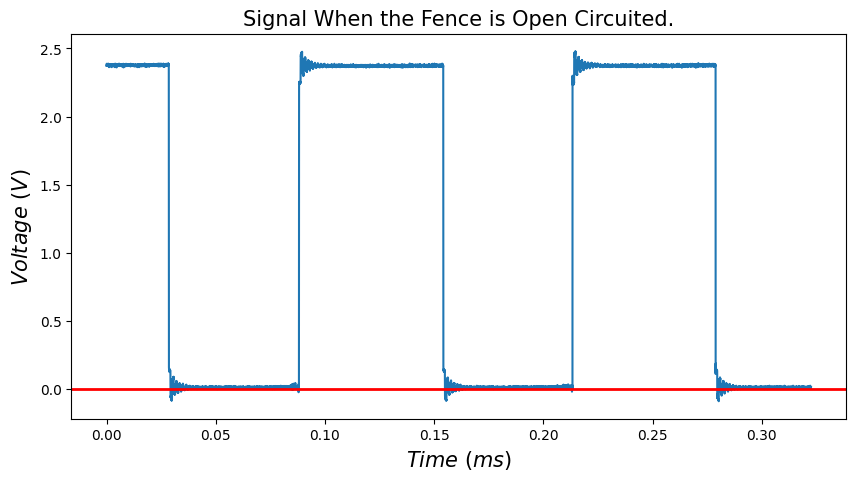

In [3]:
open_files_dir = './data/open-circuit'

#load a random file
v_open = ut.random_file_load(open_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_open, 'Signal When the Fence is Open Circuited.')

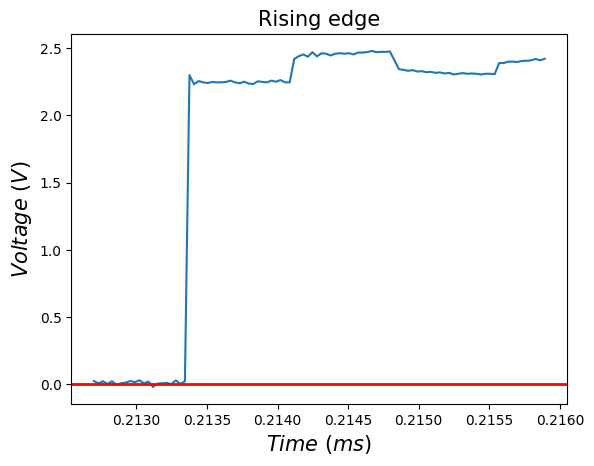

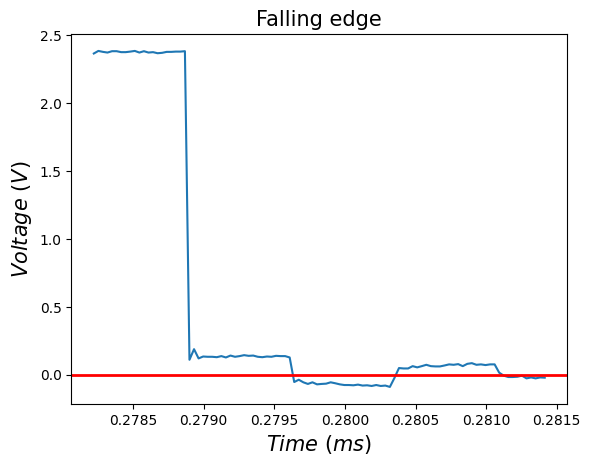

In [4]:
#locate rising a rising edge and a falling edge in the signal
# let's initialize number of edges to 1 to extract 1 falling and 1 rising edges

_num_edges = 1
open_edges_indices = ut.edges_detection(v_open, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_open, t, open_edges_indices, win_size, prior_samples)

In [5]:
print('The rising and falling edges indices are: {} and {}'.format(open_edges_indices['rising_edges'], open_edges_indices['falling_edges']))

The rising and falling edges indices are: [6613] and [8644]


### Changepoint detection

We will use changepoint detection to extract time delay between incident and reflected signals. To determine changepoints, we will use gradient.

#### 1. Rising edge


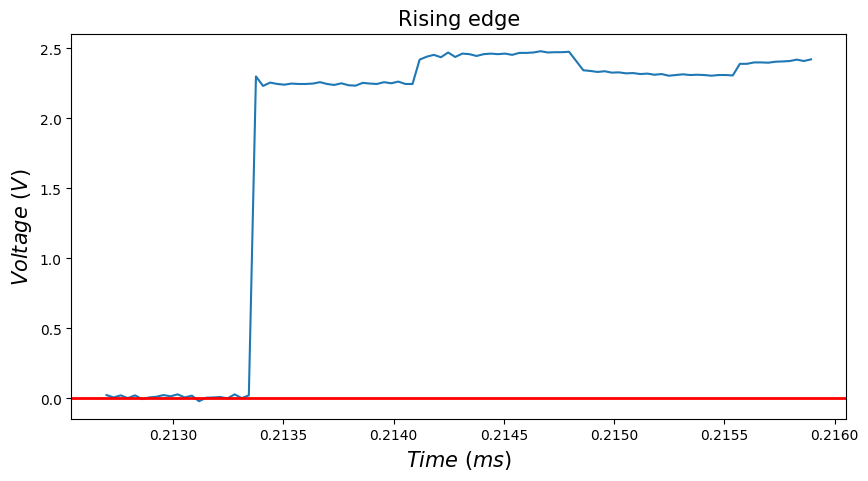

In [6]:
rising_edge_indx = open_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_open, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)

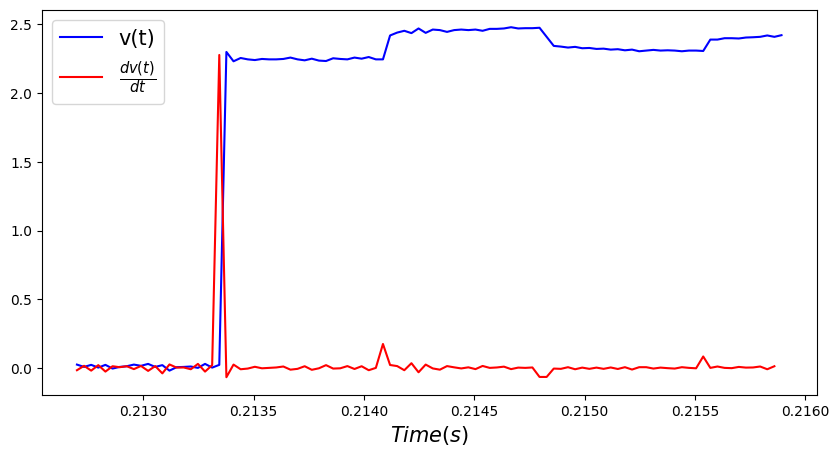

In [7]:
#let's plot
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

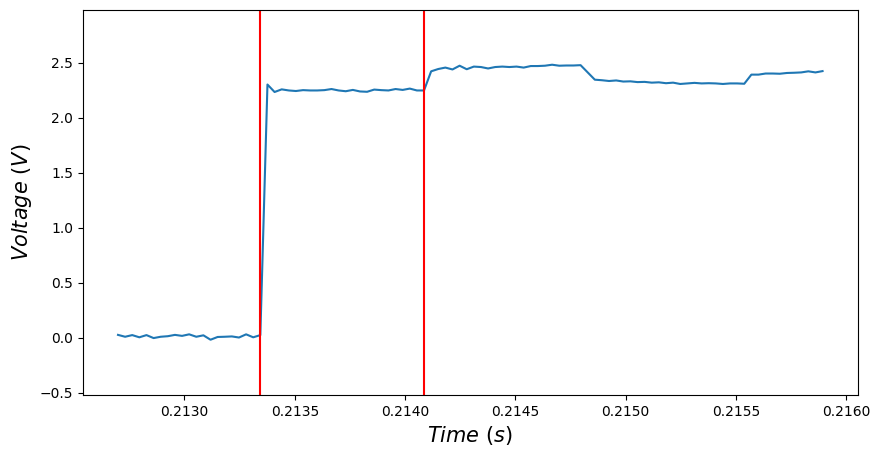

Timed delay is 0.0007420096848394231 ms


In [8]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [9]:
p_rising_fault = ut.fault_point(t_rising_delay, c, vf)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 108.91960163757892 m


In [10]:
#model performance
performance = ut.performance_metrics(106.1, p_rising_fault, metrics=['mse'])
print('Model performance metrics outcome for a single rising edge:', performance)

Model performance metrics outcome for a single rising edge: Metrics(mse=7.950153394637767, rmse=2.819601637578927)


#### 1. Falling edge

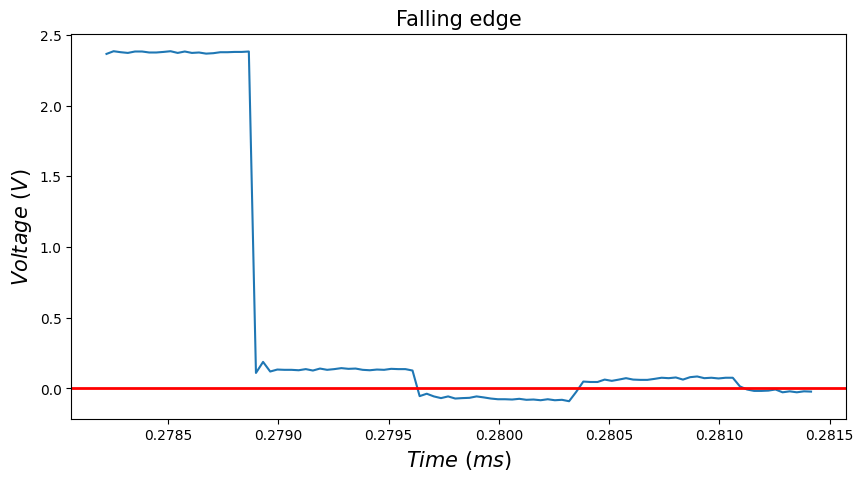

In [11]:
falling_edge_indx = open_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_open, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

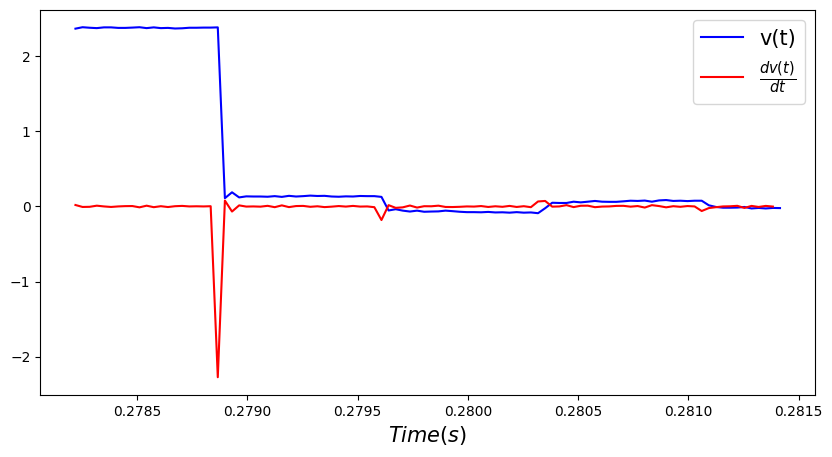

In [12]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

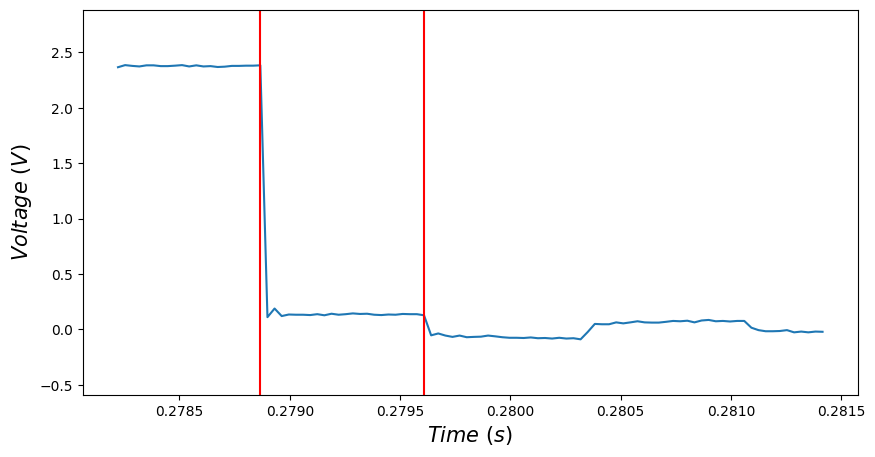

Timed delay is 0.0007420096848395064 ms


In [13]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [14]:
p_falling_fault = ut.fault_point(t_falling_delay, c, vf)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 108.91960163759114 m


In [15]:
#model performance
performance = ut.performance_metrics(106.1, p_falling_fault, metrics=['mse'])
print('Model performance metrics outcome for a single falling edge:', performance)

Model performance metrics outcome for a single falling edge: Metrics(mse=7.950153394706685, rmse=2.8196016375911483)


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [16]:
#locate rising rising edges and a falling edges in the signal
open_edges_indices = ut.edges_detection(v_open, t, num_edges, win_size, prior_samples, overlap_threshold)

print(open_edges_indices)

{'rising_edges': [2731, 6613], 'falling_edges': [8644, 4779, 884]}


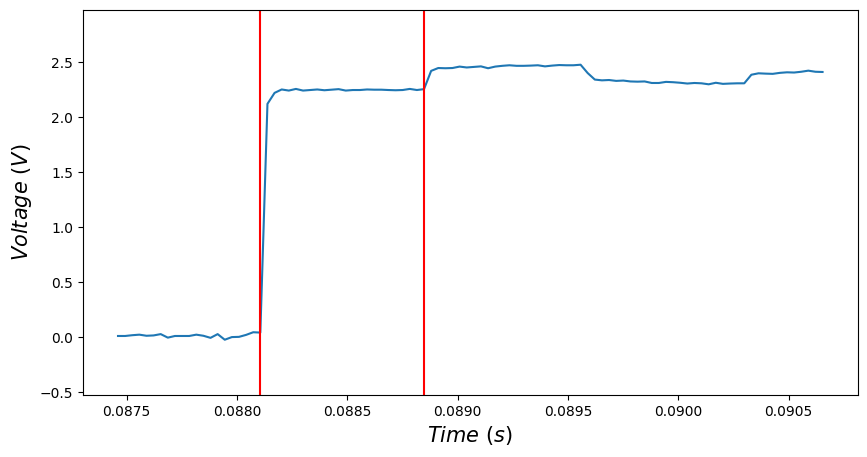

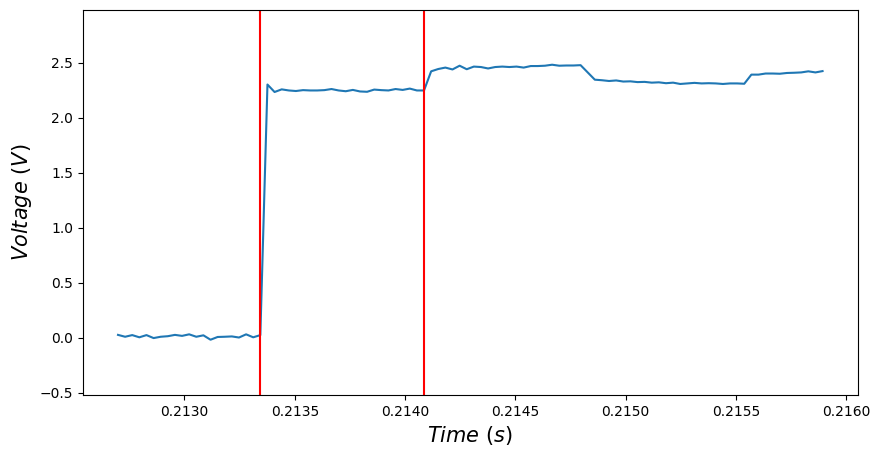

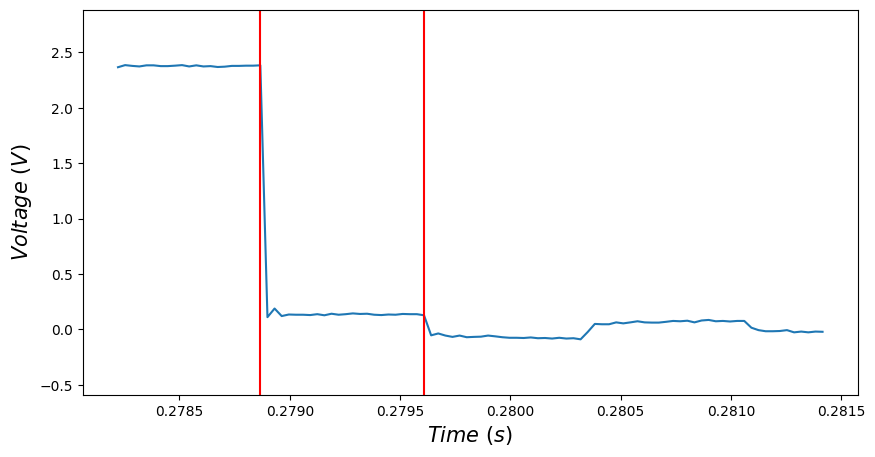

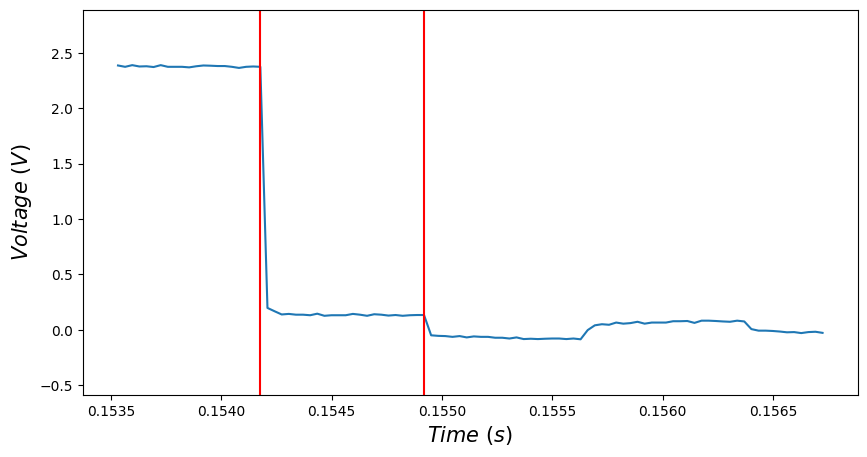

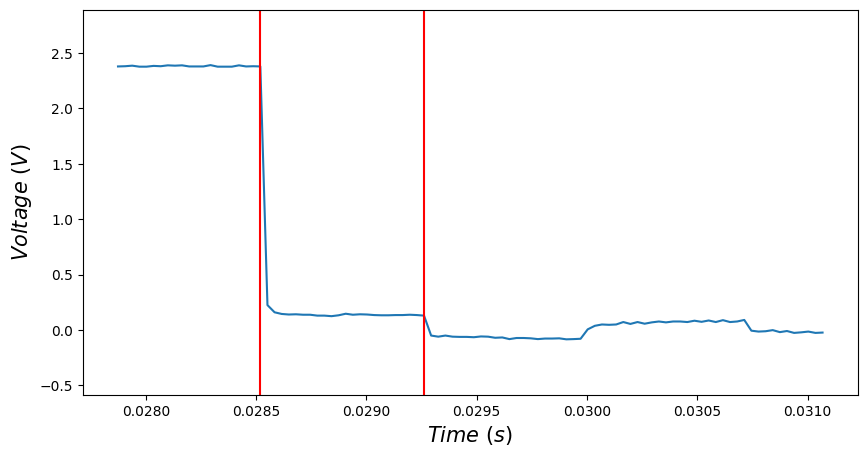

[0.00074201 0.00074201 0.00074201 0.00074201 0.00074201]
Average time delay is 0.0007420096848394564 ms


In [17]:
avg_t_open_delay,  t_open_delays = ut.avg_delay(open_edges_indices, win_size, v_open, t, prior_samples)

print(t_open_delays)
print('Average time delay is {} ms'.format(avg_t_open_delay))

In [18]:
#let's compute distance to the fault using the average time delay
p_open_fault = ut.fault_point(avg_t_open_delay, c, vf)

print('Distance to the fault is {} m'.format(p_open_fault))

Distance to the fault is 108.91960163758381 m


In [19]:
#model performance
performance = ut.performance_metrics(106.1, p_open_fault, metrics=['mse'])
print('Model performance metrics outcome for the whole signal:', performance)

Model performance metrics outcome for the whole signal: Metrics(mse=7.950153394665334, rmse=2.8196016375838155)


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [20]:
open_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
e_values = []
paths = ut.file_paths(open_files_dir) #generate paths to each file

for file_path in paths:
    v_open = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_open, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        open_edges_indices = ut.edges_detection(v_open, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_open_delay,  t_open_delays = ut.avg_delay(open_edges_indices, win_size, v_open, t, prior_samples, display=False)
        p_open_fault = ut.fault_point(avg_t_open_delay, c, vf)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_open_delay)
        distance_to_fault.append(p_open_fault)
        e_values.append(106.1)
        
open_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_open = pd.DataFrame(open_circuit_files)
        
df_open

,files,avg_time_delay_ms,distance_to_fault
0,./data/open-circuit/open-106-1.csv,0.000742,108.919602
1,./data/open-circuit/open-106-10.csv,0.000742,108.919602
2,./data/open-circuit/open-106-13.csv,0.000742,108.919602
3,./data/open-circuit/open-106-14.csv,0.000742,108.919602
4,./data/open-circuit/open-106-15.csv,0.000742,108.919602
5,./data/open-circuit/open-106-16.csv,0.000742,108.919602
6,./data/open-circuit/open-106-17.csv,0.000742,108.919602
7,./data/open-circuit/open-106-18.csv,0.000710,104.183967
8,./data/open-circuit/open-106-2.csv,0.000742,108.919602
9,./data/open-circuit/open-106-21.csv,0.000742,108.919602


In [21]:
type(df_open['distance_to_fault'][1])

numpy.float64

In [22]:
#model performance
performance = ut.performance_metrics(e_values, distance_to_fault)
print('Model performance metrics outcome for all data:', performance)

Model performance metrics outcome for all data: Metrics(mse=7.607835785942443, rmse=2.7582305534422686, mae=2.7473161638743737, irm=1.0)


## Pulses applied to short circuited fence

Short circuits were simulated on the fence at intervals. For each simulation, a signal was applied, sampled at the input port and saved for analysis. Using these sampled signals, we will develop a tdr algorithm to locate the distance of the short circuit fault from the input port.

<p align="center" width="100%">
    <img width="32%" src="images/short-circuit.jpg"> 
</p>


### 2.52 m
Short circuit at 2.52 m from the input port

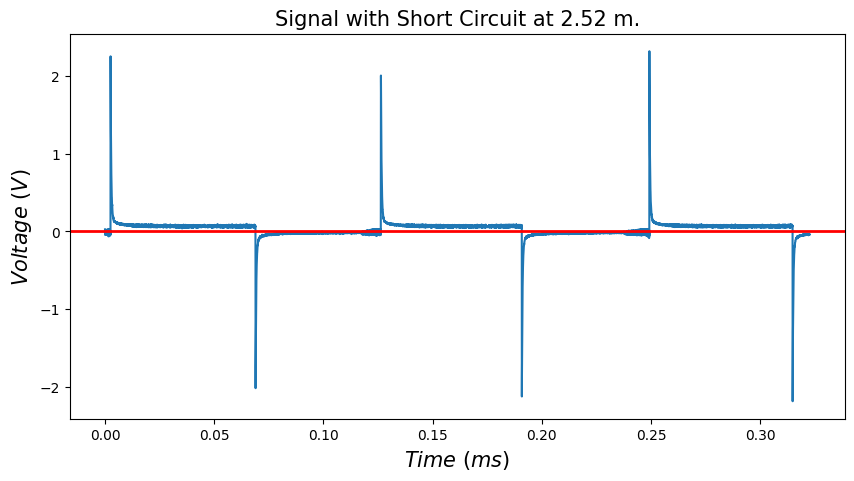

In [23]:
short_3m_files_dir = './data/short-circuit/2m'

#load a random file
v_short_3m = ut.random_file_load(short_3m_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_short_3m, 'Signal with Short Circuit at 2.52 m.')

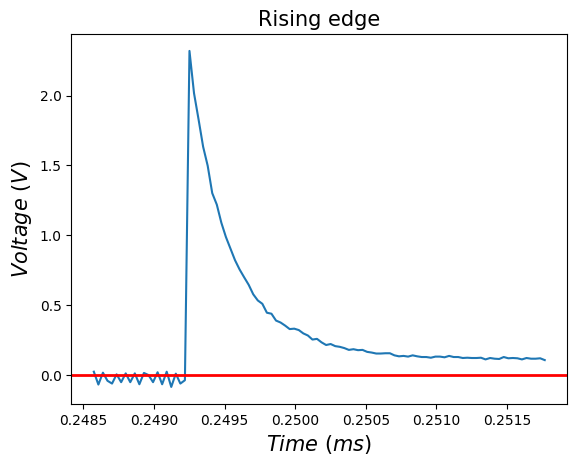

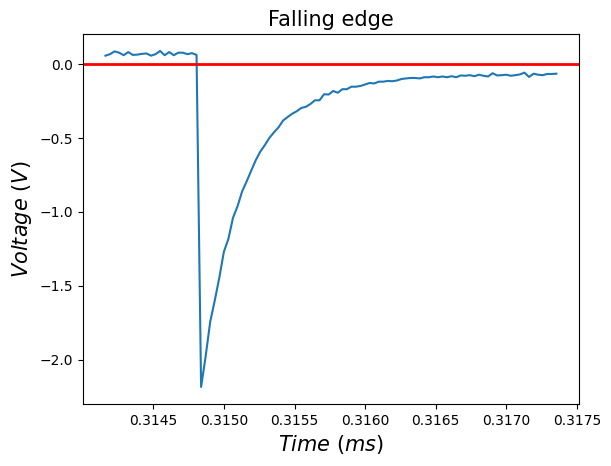

In [24]:
#locate rising a rising edge and a falling edge in the signal
short_3m_edges_indices = ut.edges_detection(v_short_3m, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_short_3m, t, short_3m_edges_indices, win_size, prior_samples)

#### 1. Rising edge

Change point detection on a rising edge

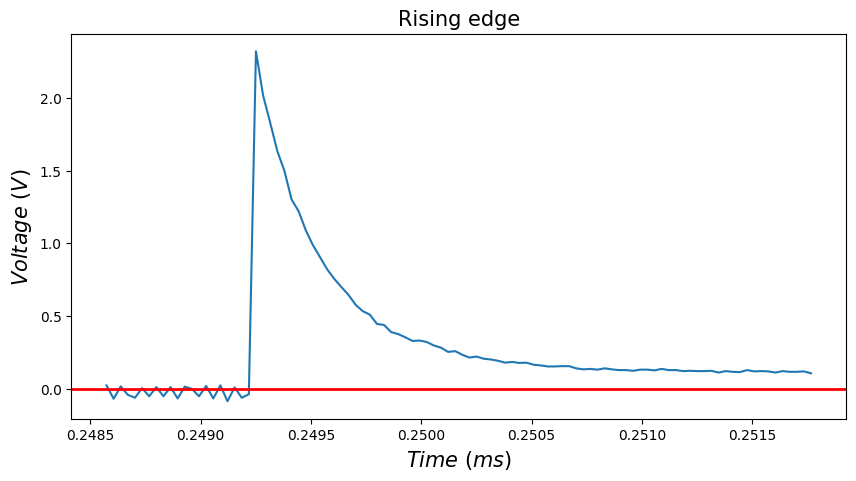

In [25]:
rising_edge_indx = short_3m_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_short_3m, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)

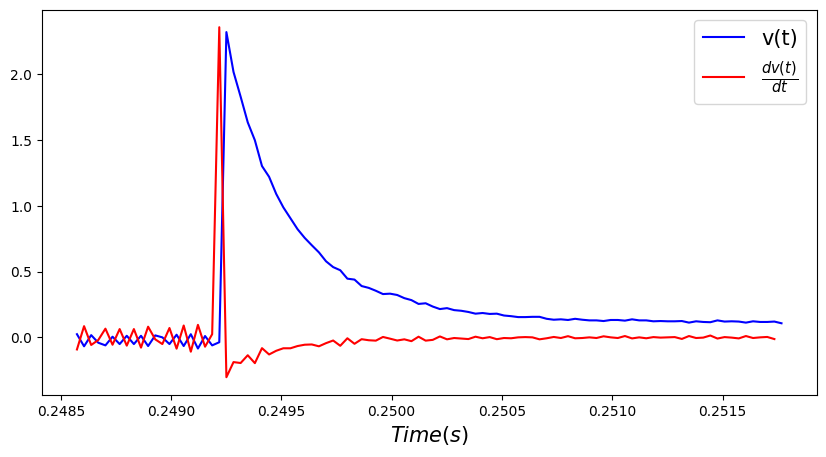

In [26]:
#let's plot the derivative of the signal and the signal
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

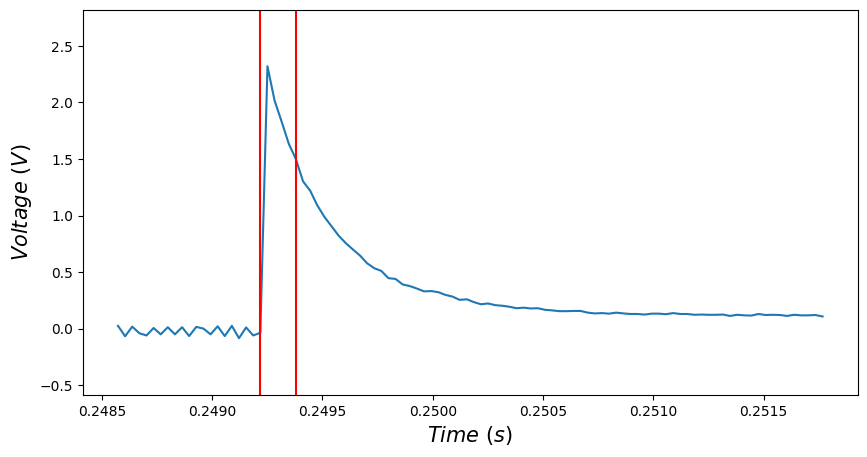

Timed delay is 0.00016130645322595671 ms


In [27]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [28]:
p_rising_fault = ut.fault_point(t_rising_delay, c, vf)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 23.678174269038188 m


#### 2. Falling edge

Change point detection on a falling edge

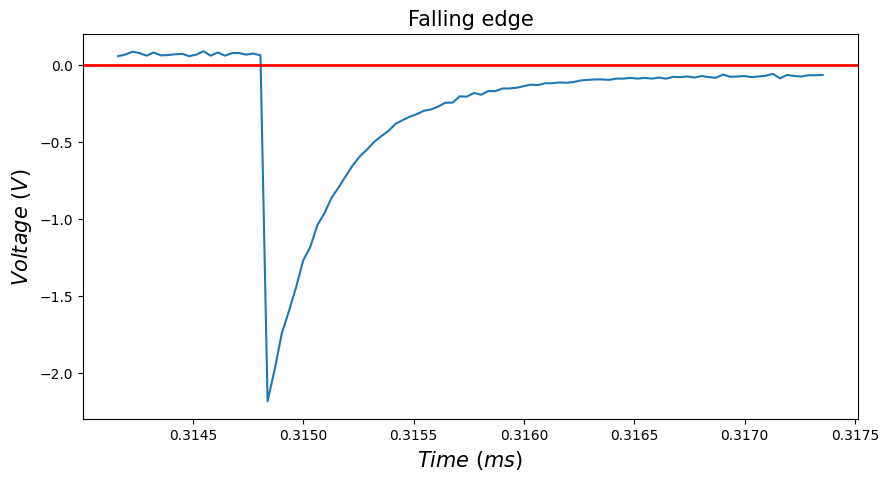

In [29]:
falling_edge_indx = short_3m_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_short_3m, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

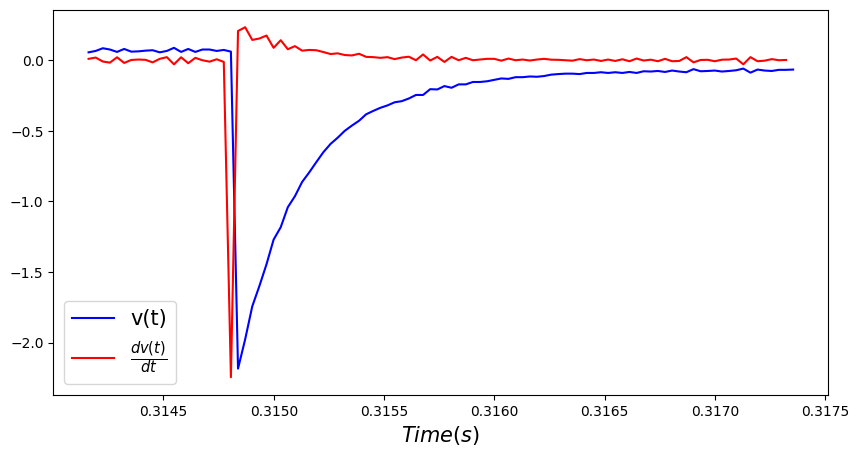

In [30]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

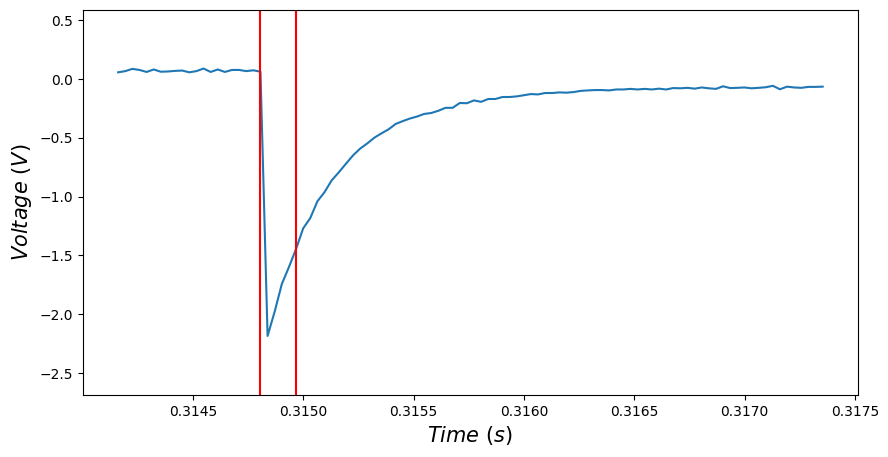

Timed delay is 0.00016130645322598447 ms


In [31]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [32]:
p_falling_fault = ut.fault_point(t_falling_delay, c, vf)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 23.678174269042263 m


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [33]:
#locate rising rising edges and a falling edges in the signal
short_3m_edges_indices = ut.edges_detection(v_short_3m, t, num_edges, win_size, prior_samples, overlap_threshold)

print(short_3m_edges_indices)

{'rising_edges': [3914, 78, 7725], 'falling_edges': [9758, 5915, 2136]}


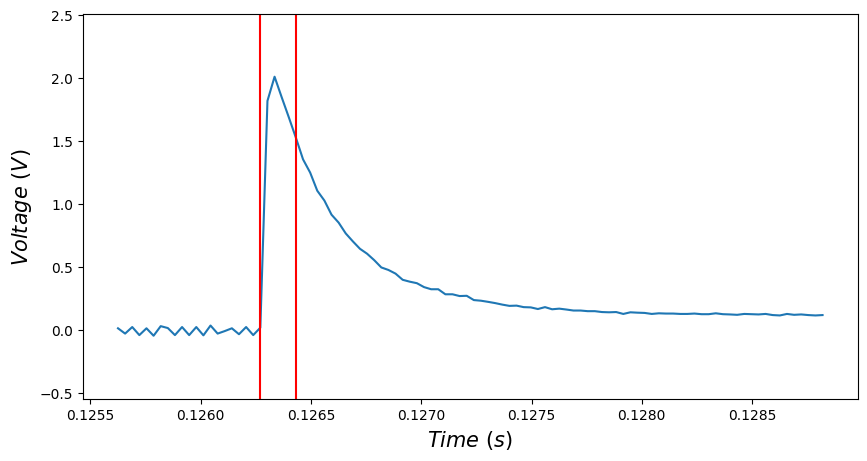

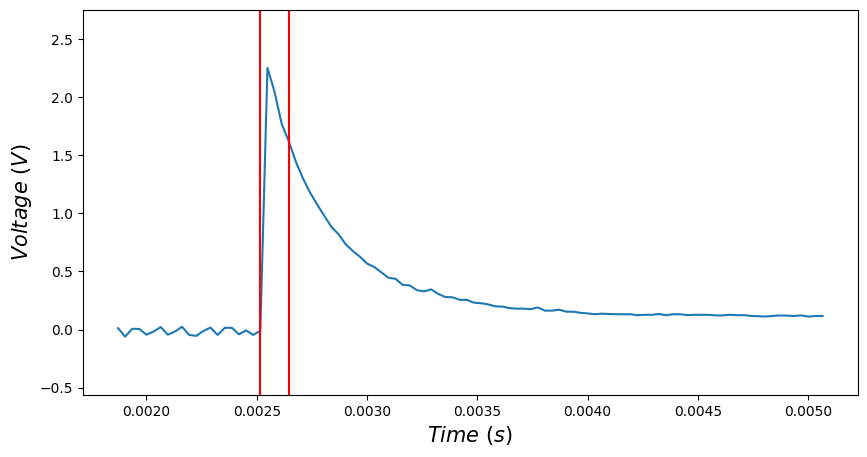

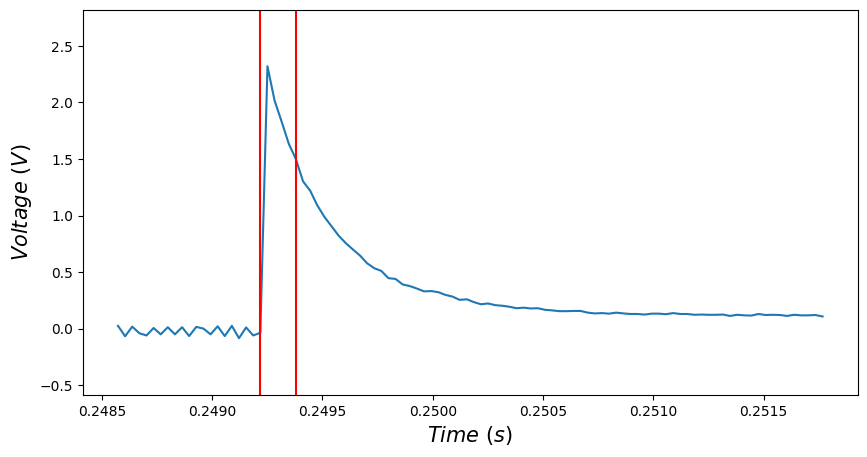

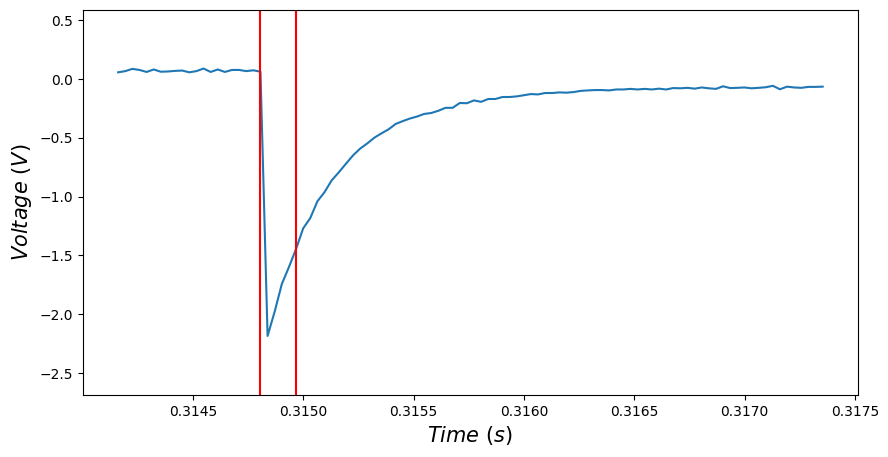

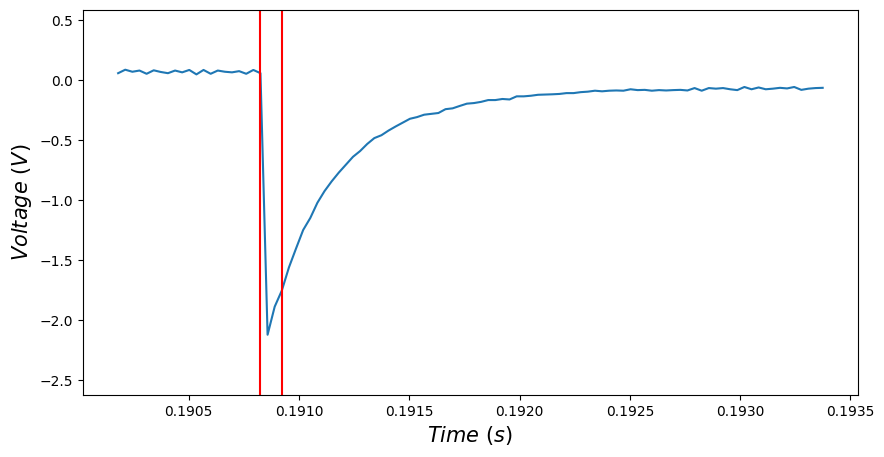

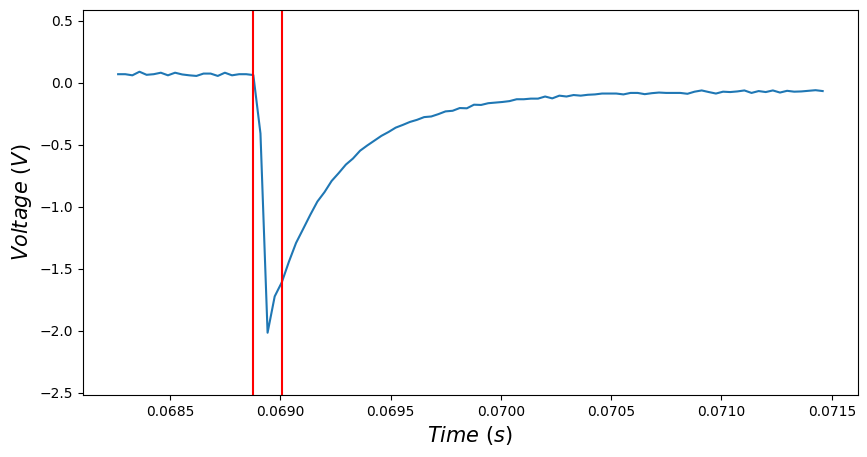

[1.61306453e-04 9.67838719e-05 1.61306453e-04 1.61306453e-04
 9.67838719e-05 9.67838719e-05]
Average time delay is 0.0001290451625807811 ms


In [34]:
avg_t_short_3m_delay,  t_short_3m_delays = ut.avg_delay(short_3m_edges_indices, win_size, v_short_3m, t, prior_samples)

print(t_short_3m_delays)
print('Average time delay is {} ms'.format(avg_t_short_3m_delay))

In [35]:
#let's compute distance to the fault using the average time delay
p_short_fault = ut.fault_point(avg_t_short_3m_delay, c, vf)

print('Distance to the fault is {} m'.format(p_short_fault))

Distance to the fault is 18.942539415232858 m


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [36]:
short_3m_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
paths = ut.file_paths(short_3m_files_dir) #generate paths to each file

for file_path in paths:
    v_short_3m = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_short_3m, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        short_3m_edges_indices = ut.edges_detection(v_short_3m, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_short_3m_delay,  t_short_3m_delays = ut.avg_delay(short_3m_edges_indices, win_size, v_short_3m, t, prior_samples, display=False)
        p_short_fault = ut.fault_point(avg_t_short_3m_delay, c, vf)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_short_3m_delay)
        distance_to_fault.append(p_short_fault)
        
short_3m_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_short_3m = pd.DataFrame(short_3m_circuit_files)
        
df_short_3m

,files,avg_time_delay_ms,distance_to_fault
0,./data/short-circuit/2m/short-106-2-1.csv,0.000110,16.101159
1,./data/short-circuit/2m/short-106-2-11.csv,0.000077,11.365524
2,./data/short-circuit/2m/short-106-2-12.csv,0.000103,15.154032
3,./data/short-circuit/2m/short-106-2-13.csv,0.000097,14.206905
4,./data/short-circuit/2m/short-106-2-14.csv,0.000065,9.471270
5,./data/short-circuit/2m/short-106-2-15.csv,0.000097,14.206905
6,./data/short-circuit/2m/short-106-2-16.csv,0.000097,14.206905
7,./data/short-circuit/2m/short-106-2-17.csv,0.000129,18.942539
8,./data/short-circuit/2m/short-106-2-18.csv,0.000075,11.049815
9,./data/short-circuit/2m/short-106-2-19.csv,0.000097,14.206905
